In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import model, train, metrics

/home/firp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/firp/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
writer = SummaryWriter()

## Dataset

In [3]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [4]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [5]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 24005
Validation: 4000
Test: 4000


In [6]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [7]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


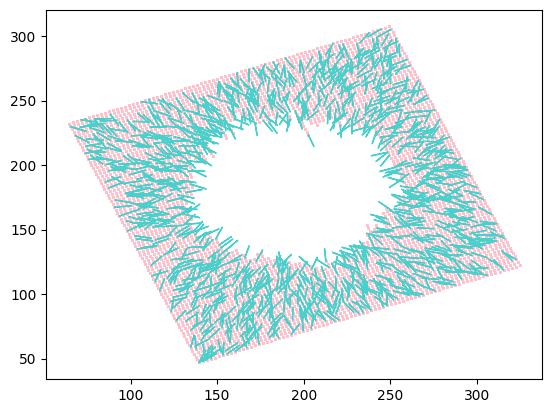

In [8]:
plotter.plot_train_data(train_data)

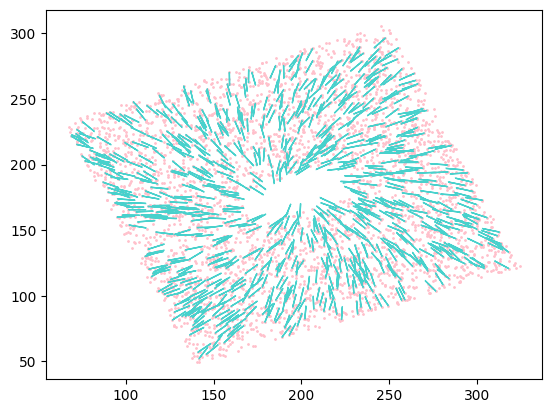

In [9]:
plotter.plot_data(val_data)

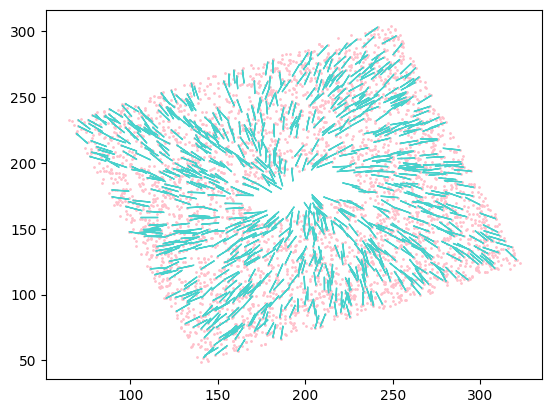

In [10]:
plotter.plot_data(test_data)

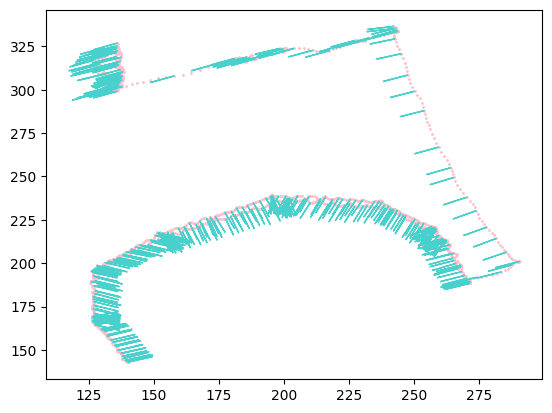

In [11]:
plotter.plot_data(real_data)

In [12]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation before filtering: 4000


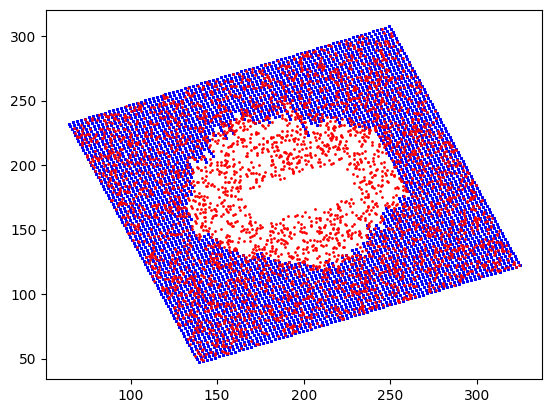

In [13]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2160.35it/s]


Validation after filtering: 3253


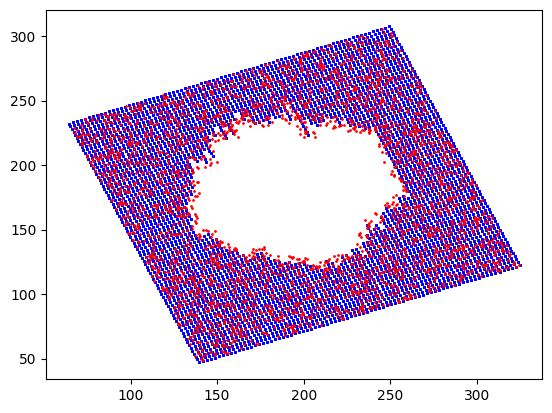

In [14]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


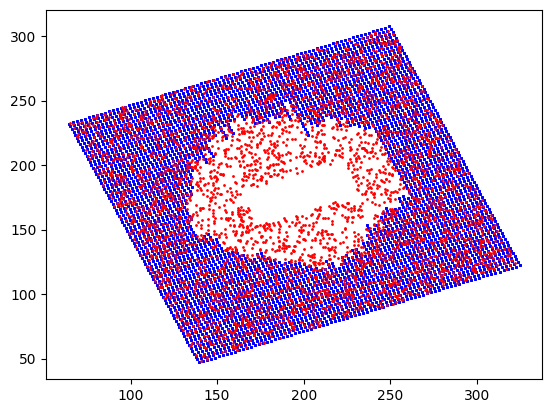

In [15]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2059.46it/s]


Test after filtering: 3271


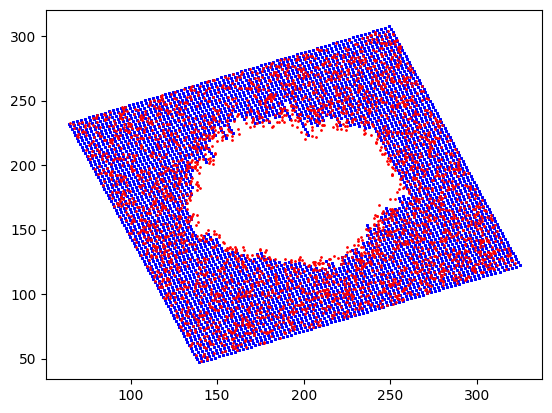

In [16]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

iou: 0.9040500183811557
yaw difference tensor(0.2392) deg
localization error:  0.48598066 meters


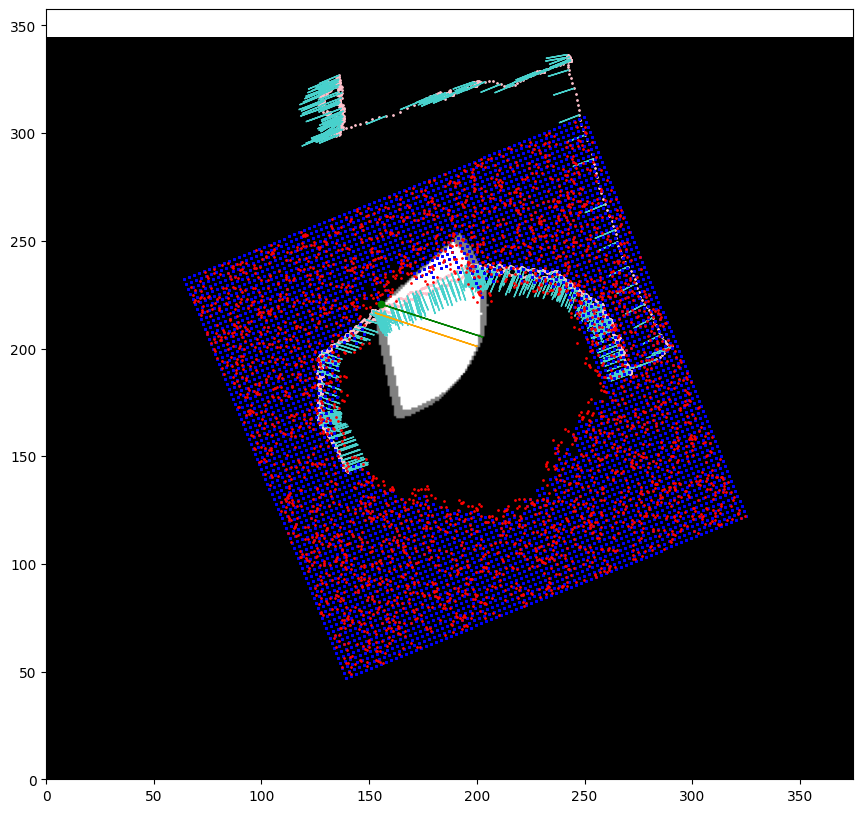

<Figure size 640x480 with 0 Axes>

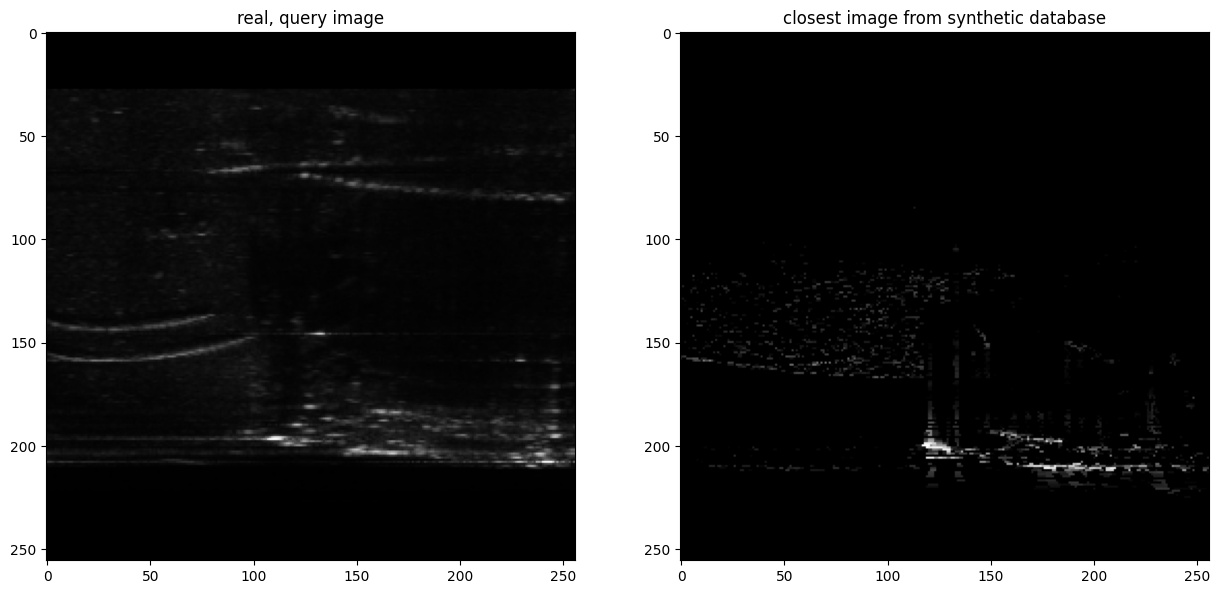

In [17]:
visualizer.localization(train_data, val_data, real_data)

In [18]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 24005
Validation: 3253
Test: 3271


In [19]:
val_data = visualizer.check_gt(train_data, val_data)

In [20]:
test_data = visualizer.check_gt(train_data, test_data)

In [21]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 24005
Validation: 3251
Test: 3270


In [22]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [23]:
net = model.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [24]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

## Training Pipeline

### Train epochs

In [25]:
best_model_path = train.train(writer, train_data, train_dataloader, val_data, net, optimizer, scheduler, drop, recocriterion, locacriterion)

epoch:  1


100%|███████████████████████████████████████| 1501/1501 [24:06<00:00,  1.04it/s]


train loss mean: 1.933109605506647
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:06<00:00, 97.40it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 97.39it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:56<00:00,  7.81it/s]


average localization error: 8.6398 meters
average orientation error : 70.0220 degrees
epoch:  2


100%|███████████████████████████████████████| 1501/1501 [23:56<00:00,  1.04it/s]


train loss mean: 0.004346207916447464
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:02<00:00, 98.83it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 96.51it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:50<00:00,  7.92it/s]


average localization error: 6.9802 meters
average orientation error : 57.5771 degrees
epoch:  3


100%|███████████████████████████████████████| 1501/1501 [23:45<00:00,  1.05it/s]


train loss mean: 0.004028931186273247
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.59it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 96.55it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:47<00:00,  7.98it/s]


average localization error: 5.0297 meters
average orientation error : 40.6656 degrees
epoch:  4


100%|███████████████████████████████████████| 1501/1501 [23:43<00:00,  1.05it/s]


train loss mean: 0.004819573398349406
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.64it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 98.07it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:47<00:00,  7.98it/s]


average localization error: 6.5531 meters
average orientation error : 50.3192 degrees
epoch:  5


100%|███████████████████████████████████████| 1501/1501 [23:37<00:00,  1.06it/s]


train loss mean: 0.004332495494674318
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:01<00:00, 99.29it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:32<00:00, 99.95it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:48<00:00,  7.95it/s]


average localization error: 6.2878 meters
average orientation error : 47.8169 degrees
epoch:  6


100%|███████████████████████████████████████| 1501/1501 [23:44<00:00,  1.05it/s]


train loss mean: 0.005087137434179885
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:02<00:00, 99.13it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:32<00:00, 99.18it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:46<00:00,  7.99it/s]


average localization error: 1.7702 meters
average orientation error : 13.3710 degrees
epoch:  7


100%|███████████████████████████████████████| 1501/1501 [23:40<00:00,  1.06it/s]


train loss mean: 0.005107875170215944
computing dataset descriptors


100%|████████████████████████████████████| 24005/24005 [03:59<00:00, 100.36it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:31<00:00, 102.15it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:47<00:00,  7.98it/s]


average localization error: 3.2511 meters
average orientation error : 26.6486 degrees
epoch:  8


100%|███████████████████████████████████████| 1501/1501 [23:38<00:00,  1.06it/s]


train loss mean: 0.005132072378876932
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:01<00:00, 99.42it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:32<00:00, 100.06it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:48<00:00,  7.95it/s]


average localization error: 4.3402 meters
average orientation error : 33.4696 degrees
epoch:  9


100%|███████████████████████████████████████| 1501/1501 [23:42<00:00,  1.06it/s]


train loss mean: 0.005398725294262955
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:04<00:00, 98.36it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 97.63it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:52<00:00,  7.89it/s]


average localization error: 3.2546 meters
average orientation error : 26.6821 degrees
epoch:  10


100%|███████████████████████████████████████| 1501/1501 [23:37<00:00,  1.06it/s]


train loss mean: 13096.692123461513
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:04<00:00, 98.01it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 96.19it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:49<00:00,  7.94it/s]


average localization error: 11.8141 meters
average orientation error : 91.1318 degrees
epoch:  11


100%|███████████████████████████████████████| 1501/1501 [23:33<00:00,  1.06it/s]


train loss mean: 0.12378232800795745
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:02<00:00, 98.94it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 96.93it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:50<00:00,  7.92it/s]


average localization error: 11.7112 meters
average orientation error : 90.2533 degrees
epoch:  12


100%|███████████████████████████████████████| 1501/1501 [23:37<00:00,  1.06it/s]


train loss mean: 0.030487166994377264
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:04<00:00, 98.17it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 96.45it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:51<00:00,  7.91it/s]


average localization error: 11.7745 meters
average orientation error : 89.2692 degrees
epoch:  13


100%|███████████████████████████████████████| 1501/1501 [23:36<00:00,  1.06it/s]


train loss mean: 0.0085769898095587
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.53it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 98.18it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:52<00:00,  7.88it/s]


average localization error: 11.8345 meters
average orientation error : 91.0838 degrees
epoch:  14


100%|███████████████████████████████████████| 1501/1501 [23:37<00:00,  1.06it/s]


train loss mean: 0.003907580416944923
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.43it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 96.96it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:48<00:00,  7.95it/s]


average localization error: 11.6199 meters
average orientation error : 89.1810 degrees
epoch:  15


100%|███████████████████████████████████████| 1501/1501 [23:38<00:00,  1.06it/s]


train loss mean: 0.0028207226031876204
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:06<00:00, 97.31it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 97.33it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:51<00:00,  7.91it/s]


average localization error: 11.6939 meters
average orientation error : 90.8384 degrees
epoch:  16


100%|███████████████████████████████████████| 1501/1501 [23:38<00:00,  1.06it/s]


train loss mean: 0.0024919330071394817
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:04<00:00, 98.24it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 98.37it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:49<00:00,  7.93it/s]


average localization error: 11.5946 meters
average orientation error : 89.6854 degrees
epoch:  17


100%|███████████████████████████████████████| 1501/1501 [23:37<00:00,  1.06it/s]


train loss mean: 0.0023673174956777465
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:02<00:00, 98.91it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 98.31it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:49<00:00,  7.94it/s]


average localization error: 11.6924 meters
average orientation error : 89.2351 degrees
epoch:  18


100%|███████████████████████████████████████| 1501/1501 [23:37<00:00,  1.06it/s]


train loss mean: 0.002318106009392223
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:04<00:00, 98.34it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:32<00:00, 98.78it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:50<00:00,  7.92it/s]


average localization error: 11.5082 meters
average orientation error : 88.9736 degrees
epoch:  19


100%|███████████████████████████████████████| 1501/1501 [23:35<00:00,  1.06it/s]


train loss mean: 0.0022793735993615317
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.38it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 96.82it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:48<00:00,  7.95it/s]


average localization error: 11.2651 meters
average orientation error : 87.8132 degrees
epoch:  20


100%|███████████████████████████████████████| 1501/1501 [23:36<00:00,  1.06it/s]


train loss mean: 1499.9289765504293
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.65it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:32<00:00, 100.78it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:49<00:00,  7.95it/s]


average localization error: 11.6883 meters
average orientation error : 89.1646 degrees
epoch:  21


100%|███████████████████████████████████████| 1501/1501 [23:35<00:00,  1.06it/s]


train loss mean: 0.48722879173634925
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.59it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 96.90it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:50<00:00,  7.92it/s]


average localization error: 11.4842 meters
average orientation error : 88.1579 degrees
epoch:  22


100%|███████████████████████████████████████| 1501/1501 [23:36<00:00,  1.06it/s]


train loss mean: 0.11148735798205399
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:02<00:00, 98.80it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 97.26it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:48<00:00,  7.95it/s]


average localization error: 11.1933 meters
average orientation error : 87.1752 degrees
epoch:  23


100%|███████████████████████████████████████| 1501/1501 [23:35<00:00,  1.06it/s]


train loss mean: 0.03586197046589089
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:01<00:00, 99.26it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 98.41it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:55<00:00,  7.83it/s]


average localization error: 10.7591 meters
average orientation error : 85.7792 degrees
epoch:  24


100%|███████████████████████████████████████| 1501/1501 [23:36<00:00,  1.06it/s]


train loss mean: 0.014413789580442721
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.49it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 98.02it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [06:51<00:00,  7.90it/s]


average localization error: 10.5872 meters
average orientation error : 81.8505 degrees


In [26]:
metrics.get_descriptors(train_data, val_data, net)

100%|█████████████████████████████████████| 24005/24005 [04:00<00:00, 99.66it/s]


computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:01<00:00, 99.53it/s]


descriptors computed!


/home/firp/Desktop/Notebook_bsd/metrics.py:87: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_pred_embeds = torch.Tensor(train_data.descriptors)


computing dataset descriptors


100%|██████████████████████████████████████| 3251/3251 [00:32<00:00, 100.03it/s]


descriptors computed!
torch.Size([3251]) torch.Size([3251, 5])
avg_metric_e     : tensor(118.1195)
avg_metric_e_top5: tensor(52.9392)


## Visualize Training results on Test data

### Load the checkpoint model

In [45]:
checkpoint_path = best_model_path
checkpoint_path = f"correct_model_3/epoch_06.pth"
net = model.Model()
model.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [46]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:19<00:00, 92.53it/s]

descriptors computed!


### Visualize query results: sonar images

In [47]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-4.7458, device='cuda:0', grad_fn=<MinBackward1>) tensor(4.1101, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-2.4741, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.1694, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-4.4747, device='cuda:0', grad_fn=<MinBackward1>) tensor(6.5139, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-3.4926, device='cuda:0', grad_fn=<MinBackward1>) tensor(6.0815, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.6843, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4228, device='cuda:0', grad_fn=<MaxBackward1>)


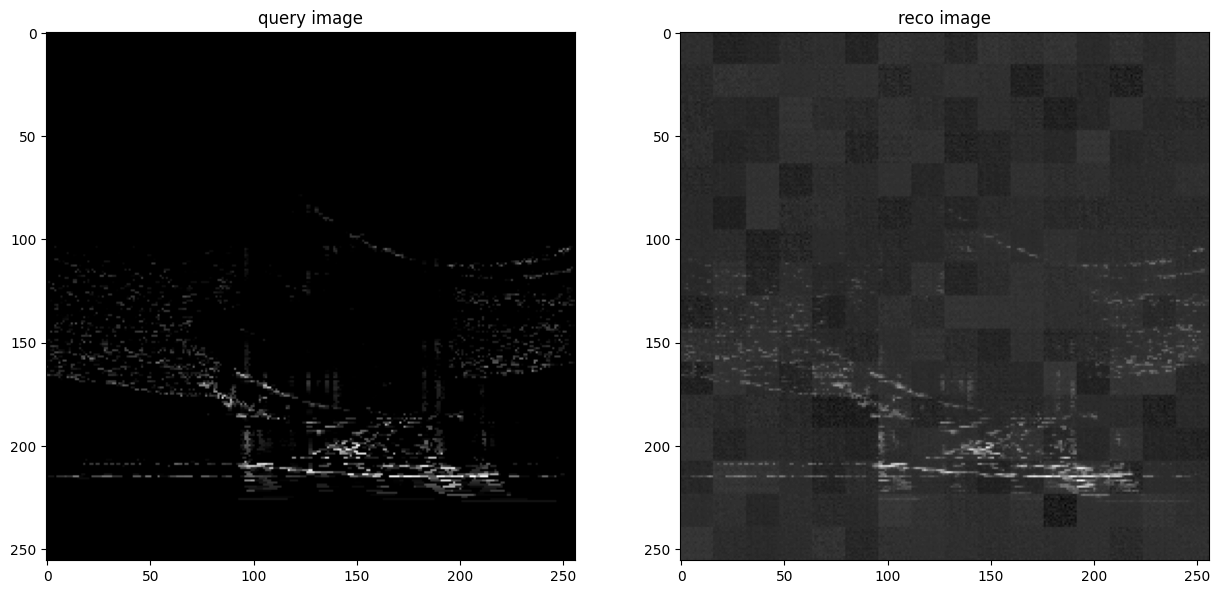

In [48]:
visualizer.analyze_feature_robustness(train_data, net)

iou: 0.8844659803798691
localization error: 0.5590 meters
orientation error : 3.6085 degrees


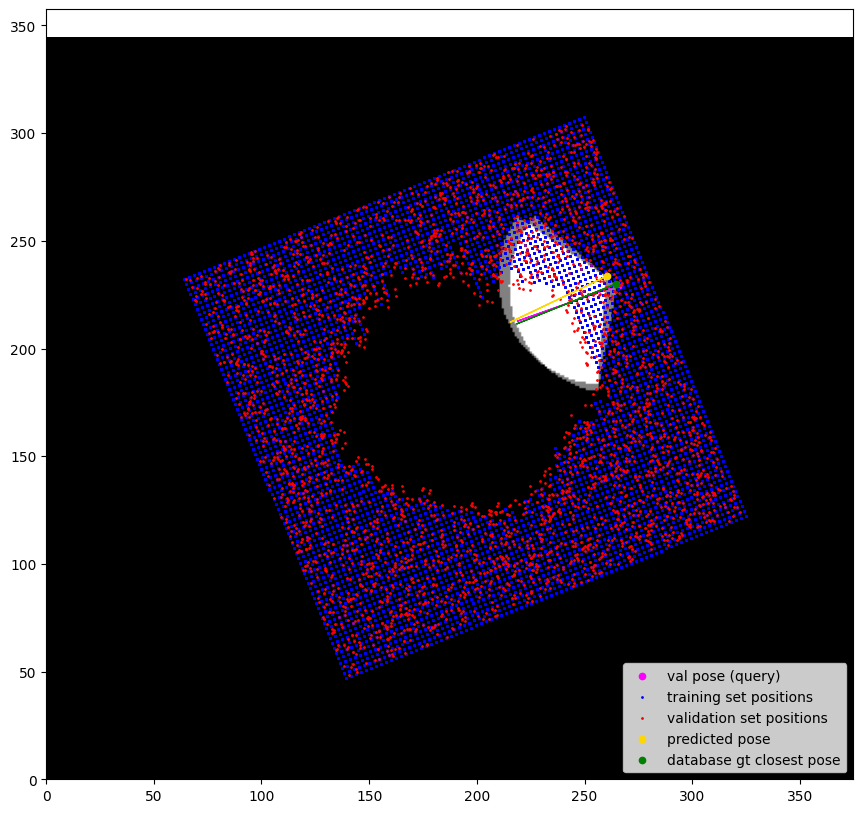

<Figure size 640x480 with 0 Axes>

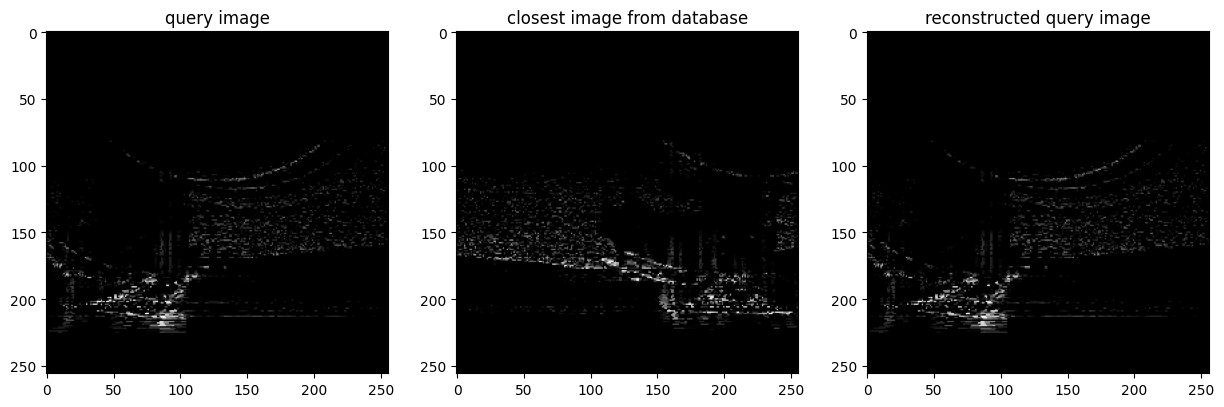

In [49]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [50]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

100%|███████████████████████████████████████| 3270/3270 [06:59<00:00,  7.80it/s]

average localization error: 1.7349 meters
average orientation error : 12.9978 degrees


In [51]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [52]:
loca_errors.argmax()

np.int64(745)

In [53]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

1.1186458
6.9512267


## process real images

query_idx: 290
241.05988 231.40015 0.6405153 -143.30118
iou: 0.0
localization error Upper:  15.156141 meters


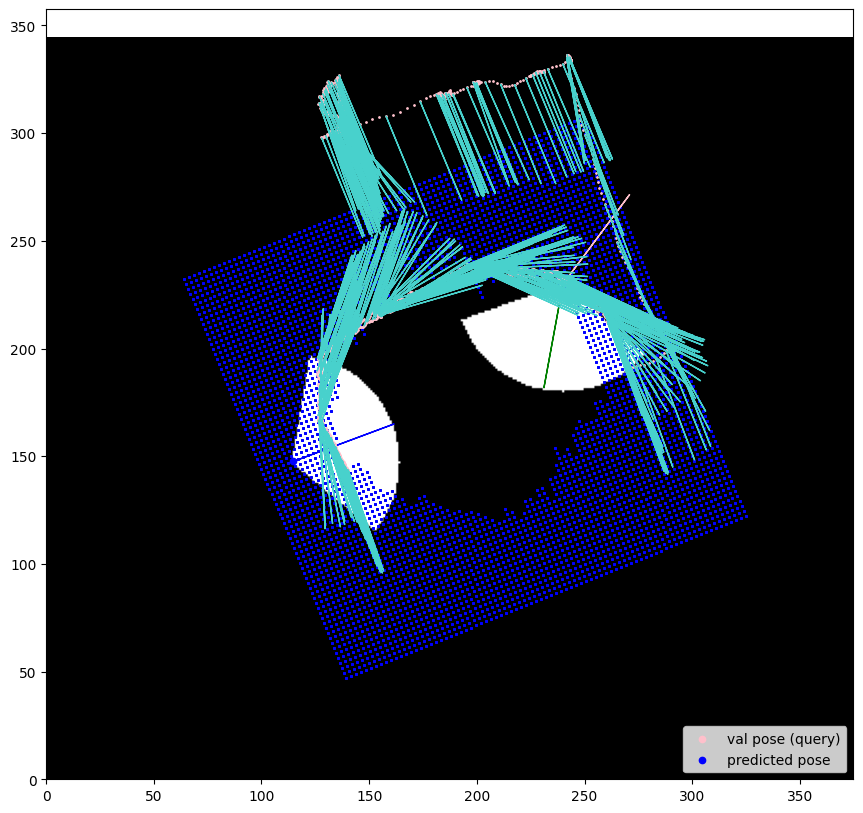

<Figure size 640x480 with 0 Axes>

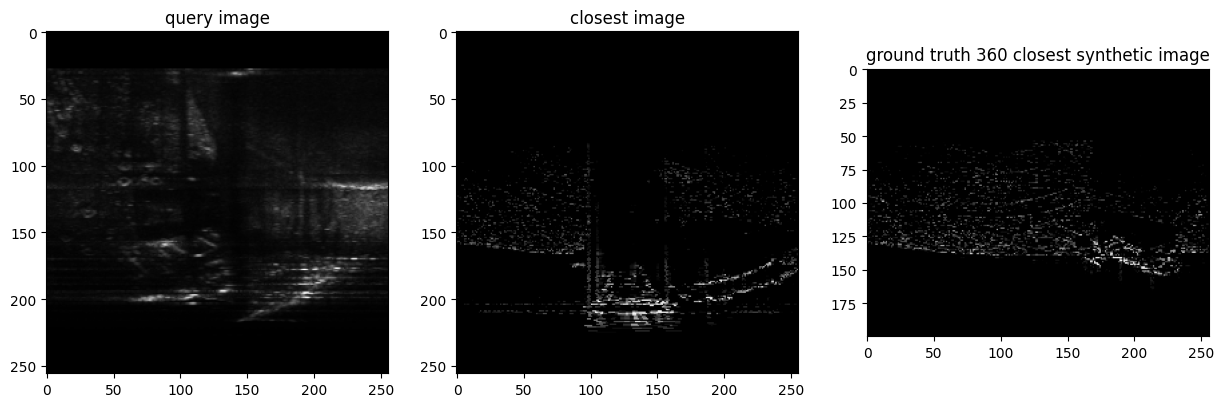

In [54]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [55]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [56]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████████| 710/710 [00:07<00:00, 98.32it/s]

descriptors computed!


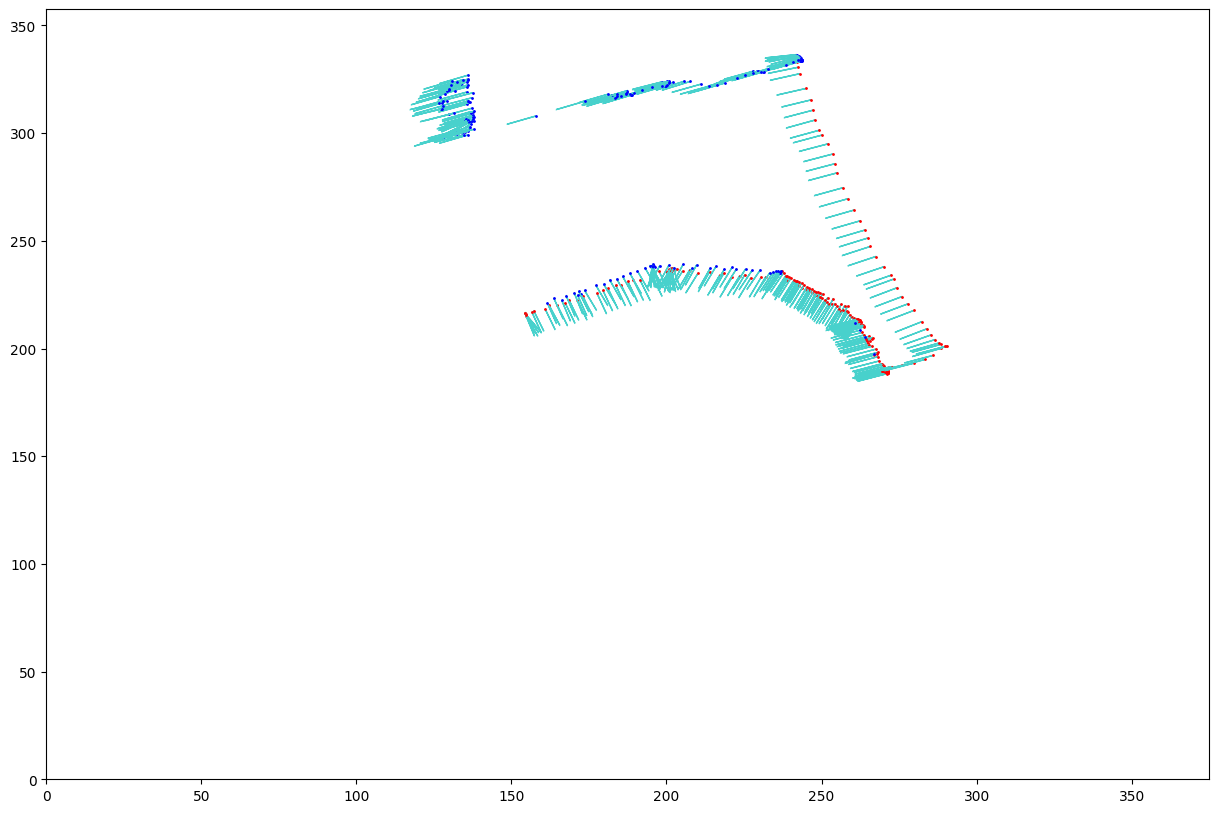

In [57]:
visualizer.visualize_real(train_data, real_data)

iou: 0.760690032578077
localization error: 1.1792 meters
orientation error : 0.5386 degrees


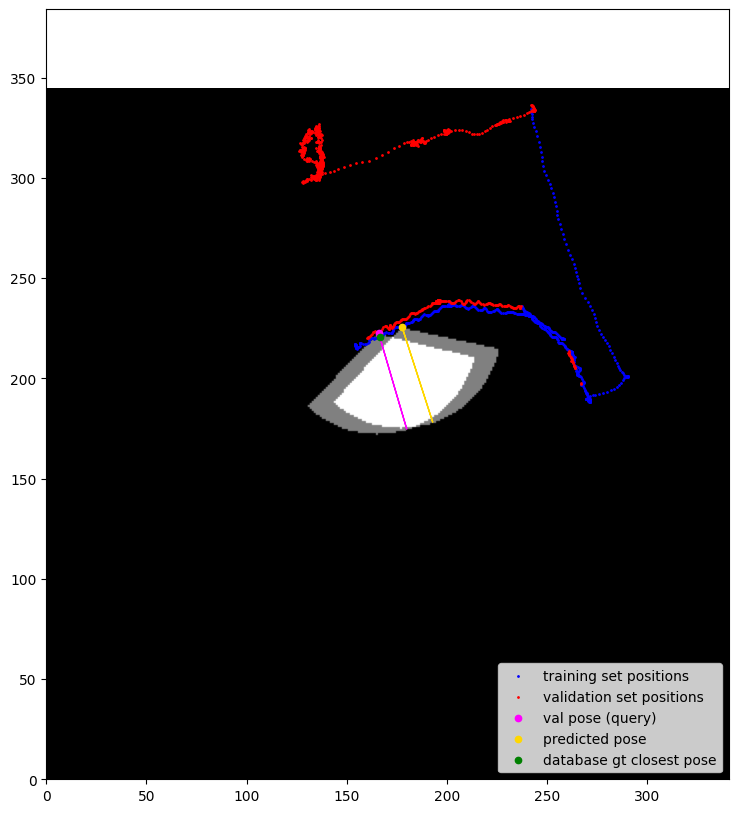

<Figure size 640x480 with 0 Axes>

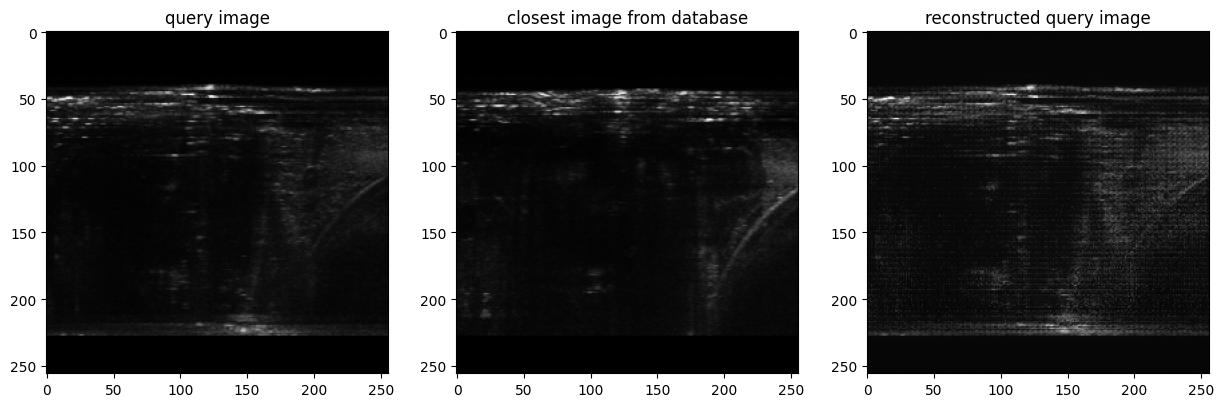

In [58]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [59]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

100%|█████████████████████████████████████████| 785/785 [00:19<00:00, 40.52it/s]

average localization error: 6.0305 meters
average orientation error : 32.6405 degrees


In [60]:
avg_orie_error.min()

np.float32(32.64053)